In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time
import pickle

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *
from HN_decomposition.Subspace.PQMF import *

from Descripteurs.audio_features import *
def RMS(x):
        return np.std(x)

figsize = (9/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

## ESTER Criterion

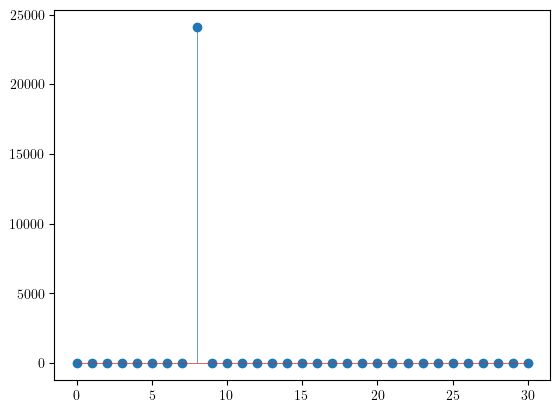

In [3]:
amps_nus = [[1, .1], [1, .2], [1, .4], [.9, .04]]

amp_noise = .1
length_smp = 512

x = np.zeros(length_smp, dtype= np.complex128)

for amp_nu in amps_nus:
    amp = amp_nu[0]
    nu = amp_nu[1]
    x += amp*np.sin(2*np.pi*nu*np.arange(length_smp))

x += amp_noise*np.random.randn(length_smp)


_, J_list = ESTER(
    x=x,
    start_idx = 15,
    window_length = 256,
    max_poles = 30,
    factor = 10
)

plt.stem(J_list)
plt.show()

## Loading the audio file

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_1_P_2.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])
sample rate : 51200 Hz


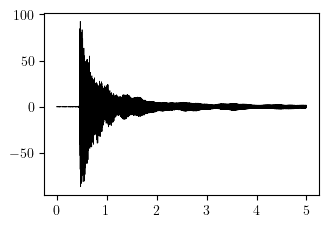

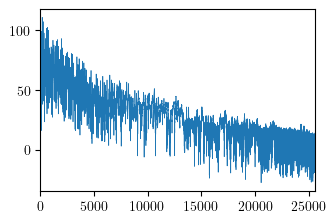

In [4]:
start_sec = .82
length_sec = 4

start_sec = 0
length_sec = 5

fileName = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM',
    'Medium_1', 'Corde_Acier', 'C_1_P_2.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

print(f'sample rate : {sr_hz_old} Hz')

plt.figure(figsize = figsize)
plt.plot(t,x,'k', linewidth = .5)
plt.show()

plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz_old), dB20(np.fft.rfft(x)))
#plt.semilogx()
plt.xlim(0, sr_hz_old/2)
plt.show()

## Resampling

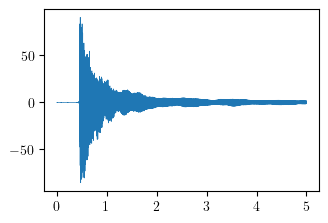

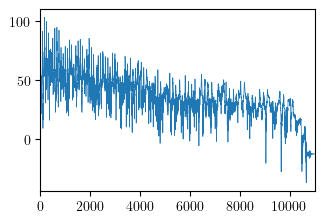

In [5]:
sr_hz = 22050
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

In [6]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Partials_Tracking", "Figures")

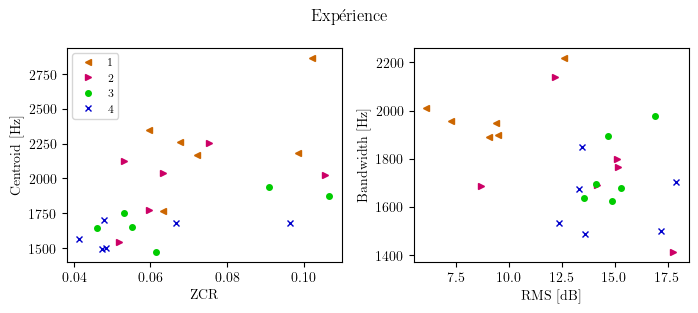

In [7]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 16

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_tables = ['Medium_1']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
#list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16000

ylim = [0,0]
_, ax = plt.subplots(nrows=  1, ncols = 2,figsize = (18/cm, 8/cm))
for p_idx, plectre_str in enumerate(list_plectres):
    color  = color_list[p_idx]
    marker = marker_list[p_idx]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    ZCR_list = []
    for corde_str in list_cordes:
        for i, table_str in enumerate(list_tables):
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            
            start_idx = np.argmax(np.abs(sig.hilbert(x)))
            x = x[start_idx:start_idx+int(3*sr_hz_old)]
            x = librosa.resample(y=x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            xHarmo, xNoise = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            x_fft = np.fft.rfft(np.real(xNoise))
            f = np.fft.rfftfreq(len(xNoise), 1/sr_hz)

            spectral_centroid = compute_spectralCentroid(
                x_fft, f)
            spectral_bandwidth = compute_spectralBandwidth(
                x_fft, f, order = 2, centroid = spectral_centroid)
            RMS = compute_RMS(x)
            ZCR = compute_ZCR(x)
            
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
            ZCR_list.append(ZCR)
    ax[0].plot(ZCR_list, centroid_list, linestyle = ' ', marker = marker, color = color, label = plectre_str[2], markersize = 4)
    ax[0].set_xlabel('ZCR')
    ax[0].set_ylabel('Centroid [Hz]')

    ax[1].plot(RMS_list, bandwidth_list, linestyle = ' ', marker = marker, color = color, label = plectre_str[2], markersize = 4)
    ax[1].set_xlabel('RMS [dB]')
    ax[1].set_ylabel('Bandwidth [Hz]')

    if table_str == 'Metal':
        metalMesRMS = np.mean(RMS_list)
#ax.set_title('Données mesurées')
ax[0].legend(prop = {'size' : 8})
plt.suptitle("Expérience")
plt.tight_layout()

plt.show()

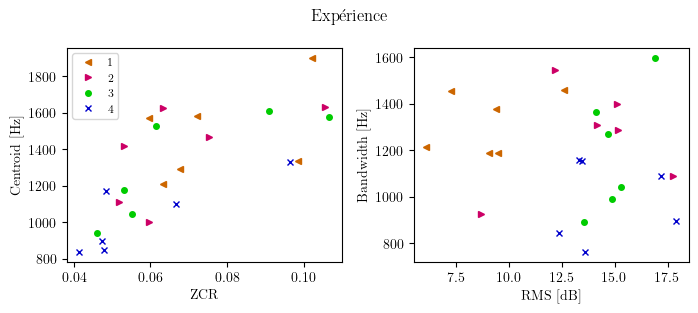

In [8]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 24

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_tables = ['Medium_1']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
#list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16000

ylim = [0,0]
_, ax = plt.subplots(nrows=  1, ncols = 2,figsize = (18/cm, 8/cm))
for p_idx, plectre_str in enumerate(list_plectres):
    color  = color_list[p_idx]
    marker = marker_list[p_idx]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    ZCR_list = []
    for corde_str in list_cordes:
        for i, table_str in enumerate(list_tables):
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            
            start_idx = np.argmax(np.abs(sig.hilbert(x)))
            x = x[start_idx:start_idx+int(3*sr_hz_old)]
            x = librosa.resample(y=x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            xHarmo, xNoise = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            x_fft = np.fft.rfft(np.real(xHarmo))
            f = np.fft.rfftfreq(len(xHarmo), 1/sr_hz)

            spectral_centroid = compute_spectralCentroid(
                x_fft, f)
            spectral_bandwidth = compute_spectralBandwidth(
                x_fft, f, order = 2, centroid = spectral_centroid)
            RMS = compute_RMS(x)
            ZCR = compute_ZCR(x)
            
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
            ZCR_list.append(ZCR)
    ax[0].plot(ZCR_list, centroid_list, linestyle = ' ', marker = marker, color = color, label = plectre_str[2], markersize = 4)
    ax[0].set_xlabel('ZCR')
    ax[0].set_ylabel('Centroid [Hz]')

    ax[1].plot(RMS_list, bandwidth_list, linestyle = ' ', marker = marker, color = color, label = plectre_str[2], markersize = 4)
    ax[1].set_xlabel('RMS [dB]')
    ax[1].set_ylabel('Bandwidth [Hz]')

    if table_str == 'Metal':
        metalMesRMS = np.mean(RMS_list)
#ax.set_title('Données mesurées')
ax[0].legend(prop = {'size' : 8})
plt.suptitle("Expérience")
plt.tight_layout()

plt.show()

ValueError: could not broadcast input array from shape (1126,) into shape (1125,)

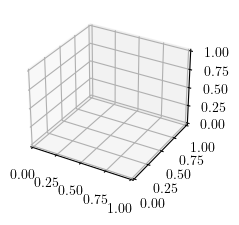

In [9]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 16

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_tables = ['Medium_1']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
#list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 6000

ylim = [0,0]
ax = plt.figure(figsize = figsize).add_subplot(projection = '3d')
for p_idx, plectre_str in enumerate(list_plectres):
    color  = color_list[p_idx]
    marker = marker_list[p_idx]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    ZCR_list = []
    for corde_str in list_cordes:
        for i, table_str in enumerate(list_tables):
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            
            start_idx = np.argmax(np.abs(sig.hilbert(x)))
            x = x[start_idx:start_idx+int(3*sr_hz_old)]
            x = librosa.resample(y=x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            xHarmo, xNoise = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            x_fft = np.fft.rfft(np.real(xNoise))
            f = np.fft.rfftfreq(len(xNoise), 1/sr_hz)

            spectral_centroid = compute_spectralCentroid(
                x_fft, f)
            spectral_bandwidth = compute_spectralBandwidth(
                x_fft, f, order = 2, centroid = spectral_centroid)
            RMS = compute_RMS(x)
            ZCR = compute_ZCR(x)
            
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
            ZCR_list.append(ZCR)
    plt.plot(ZCR_list, centroid_list, zs = bandwidth_list, linestyle = ' ', marker = marker, color = color, label = plectre_str, markersize = 4)
    plt.xlabel('ZCR')
    plt.ylabel('Centroid [Hz]')
    ax.set_zlabel('Bandwidth [Hz]')
    if table_str == 'Metal':
        metalMesRMS = np.mean(RMS_list)
#ax.set_title('Données mesurées')
plt.legend(prop = {'size' : 8})
plt.tight_layout()
plt.show()
print(ylim)

In [ ]:
#Computing RMS

folder_mesures = os.path.join(
    '..',
    '..',
    'Test_vico7')

list_tables = ['metal']
liste_cordes = ['corde_acier_1', 'corde_article']
color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']

file_name = os.path.join(
    folder_mesures,
    'medium_1',
    'corde_acier_1',
    'acc_Nt_0' + '.wav')
sr_hz, x = scipy.io.wavfile.read(file_name)
x_fft = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x), 1/sr_hz)

for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    for sample_idx in range(100):
        file_name = os.path.join(
            folder_mesures,
            table_str,
            'corde_acier_1',
            'acc_Nt_'+str(sample_idx) + '.wav'
        )
        sr_hz_old, x = scipy.io.wavfile.read(file_name)
        
        x = librosa.resample(y=x, orig_sr = sr_hz_old, target_sr = sr_hz)
        #sr_hz = sr_hz_old
        x = x[int(sr_hz*0):]
        t = np.arange(len(x))/sr_hz

        x_fft = np.fft.rfft(x)
        f = np.fft.rfftfreq(len(x), 1/sr_hz)
        RMS = compute_RMS(x)
        RMS_list.append(RMS)

metalSynRMS = np.mean(RMS_list)

### Reconnaissance des tables

In [ ]:
folder_mesures = os.path.join(
    '..',
    '..',
    'Test_vico7')

list_tables = ['medium_1', 'medium_2', 'metal', 'plexi']
liste_cordes = ['corde_acier_1']
color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']

file_name = os.path.join(
    folder_mesures,
    'medium_1',
    'corde_acier_1',
    'acc_Nt_0' + '.wav')
sr_hz, x = scipy.io.wavfile.read(file_name)
x_fft = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x), 1/sr_hz)

_, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18/cm, 8/cm))
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    for sample_idx in range(100):
        file_name = os.path.join(
            folder_mesures,
            table_str,
            'corde_acier_1',
            'acc_Nt_'+str(sample_idx) + '.wav'
        )
        sr_hz_old, x = scipy.io.wavfile.read(file_name)
        
        x = librosa.resample(y=x, orig_sr = sr_hz_old, target_sr = sr_hz)
        #sr_hz = sr_hz_old
        x = x[int(sr_hz*0):]*metalMesRMS/metalSynRMS
        t = np.arange(len(x))/sr_hz

        x_fft = np.fft.rfft(x)
        f = np.fft.rfftfreq(len(x), 1/sr_hz)

        spectral_centroid = compute_spectralCentroid(
            x_fft, f)
        spectral_bandwidth = compute_spectralBandwidth(
            x_fft, f, order = 2, centroid = spectral_centroid)
        RMS = compute_RMS(x)

        
        if dB20(RMS)>-500:
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
    ax[0].plot(RMS_list, centroid_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 3)
    ax[0].set_ylabel('Centroïde spectrale [Hz]')
    ax[0].set_xlabel('RMS [dB]')
    

    ax[1].plot(RMS_list, bandwidth_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 3)
    ax[1].set_ylabel('Largeur de bande spectrale [Hz]')
    ax[1].set_xlabel('RMS [dB]')
    
#ax[0].set_ylim(ylim[0])
#ax[1].set_ylim(ylim[1])

#plt.title("Données de synthèse")
plt.suptitle("Test_vico7")
plt.legend(prop = {'size' : 8})
plt.tight_layout()
plt.show()
print(f"sample rate : {sr_hz}")

## Testing the H+N Decomposition on synthesis samples

In [ ]:
folder_mesures = os.path.join(
    '..',
    '..',
    'Dataset_1')

list_tables = ['medium_1', 'medium_2', 'acier', 'plexi']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']

file_name = os.path.join(
    folder_mesures,
    'medium_2',
    'Wav',
    '199' + '.wav')
sr_hz, x = scipy.io.wavfile.read(file_name)
print(sr_hz)
x_fft = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x), 1/sr_hz)

xHarmo, xNoise = multiband_HN(x)

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise), rate = sr_hz))

## Computing the harmonic+noise SNR

In [ ]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384

SNR_list = []
for i, table_str in enumerate(list_tables):
    for corde_str in list_cordes:
        for plectre_str in list_plectres:
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            print(file_name)
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            xHarmo, xNoise = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            SNR_list.append(compute_RMS(xHarmo)/compute_RMS(xNoise))
            

In [ ]:
SRN_list = np.array(SNR_list)

print(dB20(np.mean(SNR_list)))
print(dB20(np.std(SNR_list)))